# EDA for the Power Generation in India

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt

import seaborn as sns

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [2]:
power_df = pd.read_csv("../input/daily-power-generation-in-india-20172020/file.csv", thousands=',', 
                       skiprows=1,
                       names=['Date', 'Region', 
                              'Thermal Actual', 'Thermal Estimated',
                              'Nuclear Actual', 'Nuclear Estimated',
                              'Hydro Actual', 'Hydro Estimated'])
state_df = pd.read_csv("../input/daily-power-generation-in-india-20172020/Region-State.csv")

The state table had some problem, so will scrape it down manually from the internet!

In [3]:
df = pd.read_html("https://en.wikipedia.org/wiki/List_of_states_and_union_territories_of_India_by_area")

state_df = df[1].drop(["Country of comparable size (land mass)", 
            "Ref", "Rank"], 
           axis=1).drop([28,35,36,37]).reset_index(drop=True)

Using the 2011 census we can also get the approximate population for each state, this is more useful than the number of states, as not all state have the same population.

In [4]:
population_df = pd.read_html("https://en.wikipedia.org/wiki/List_of_states_and_union_territories_of_India_by_population")

In [5]:
population_df = population_df[1][["State or union territory", "Population", "Area[16]", "Density[a]"]]

population_df.columns = ["State","Population","Area","Density"]

In [6]:
state_df = state_df.merge(population_df, left_on="State / Union territory (UT)",
                          right_on="State").drop(["State / Union territory (UT)"], 
                                                      axis=1)

In [7]:
state_df.Population = state_df.Population.apply(lambda x: int(x.replace(",","").replace("[b]","")))
state_df.Region = state_df.Region.apply(lambda x: "NorthEastern" if x=="Northeastern" else x)

In [8]:
state_df.groupby("Region")[["State","Population"]]\
                            .agg({"State":"count", 
                                  "Population":"sum"})

,State,Population
Region,,
Central,2,98172007
Eastern,4,270337920
NorthEastern,7,42916394
Northern,10,368790895
Southern,6,252477118
Western,4,174858334


In [9]:
state_distribution = state_df.groupby("Region")[["State","Population"]]\
                                                    .agg({"State":"count", 
                                                          "Population":"sum"})\

fig = make_subplots(rows=1, cols=2)

fig.add_trace(go.Bar(x=state_distribution.index, 
                     y=state_distribution.State,
                     name='State per Region'),
              row=1, col=1)
fig.add_trace(go.Bar(x=state_distribution.index, 
                     y=state_distribution.Population,
                     name='Population per Region'),
              row=1, col=2)

fig.update_layout(
    showlegend=False,
    title={'text': "Distribution of States and Population in Regions",
        'y':0.9,
        'x':0.5},
    yaxis_title="Frequency",
    yaxis2_title="Population",
    xaxis_title="")

fig.show()

As we can see from the plot above, the NorthEastern states even though had 7 states they have the lowest population.

There are a lot of Northern states,  while there are a very few Central State. If the data were divided into more sub direction, i.e. NorthWest, SouthEast etc., it might have been even more useful. 

In [10]:
power_df.head()

,Date,Region,Thermal Actual,Thermal Estimated,Nuclear Actual,Nuclear Estimated,Hydro Actual,Hydro Estimated
0,2017-09-01,Northern,624.23,484.21,30.36,35.57,273.27,320.81
1,2017-09-01,Western,1106.89,1024.33,25.17,3.81,72.00,21.53
2,2017-09-01,Southern,576.66,578.55,62.73,49.80,111.57,64.78
3,2017-09-01,Eastern,441.02,429.39,NaN,NaN,85.94,69.36
4,2017-09-01,NorthEastern,29.11,15.91,NaN,NaN,24.64,21.21


In [11]:
missing = pd.DataFrame(power_df.isna().sum()/power_df.shape[0]).T

missing.style.background_gradient(cmap='Reds', axis=1)

,Date,Region,Thermal Actual,Thermal Estimated,Nuclear Actual,Nuclear Estimated,Hydro Actual,Hydro Estimated
0,0.000000,0.000000,0.000000,0.000000,0.400000,0.400000,0.000000,0.000000


40% of the Nuclear Generation data is missing :( 

Well let's start exploring a little bit about it, why is that so much of data is missing!

In [12]:
power_df[power_df["Nuclear Actual"].isna()].Region.value_counts()

NorthEastern    927
Eastern         927
Name: Region, dtype: int64

Well apparently the only regions where it has NaN values are the Easter and North Eastern regions, may be they don't have nuclear plants, let's check it by getting total energy consumption for each region and if these two regions have no nuclear energy production at all we can assume out hypothesis and impute the NaNs with 0.

In [13]:
power_columns = power_df.columns.difference(["Date","Region"])
power_df.groupby("Region")[power_columns].sum()\
                   .style.background_gradient(cmap='hsv',
                                              subset=(["Eastern",
                                                       "NorthEastern"],
                                                      ["Nuclear Actual",
                                                      "Nuclear Estimated"]))

,Hydro Actual,Hydro Estimated,Nuclear Actual,Nuclear Estimated,Thermal Actual,Thermal Estimated
Region,,,,,,
Eastern,44032.600000,47075.590000,0.000000,0.000000,449431.260000,437541.790000
NorthEastern,16117.040000,12494.700000,0.000000,0.000000,29835.830000,31017.170000
Northern,169298.160000,179789.230000,25293.920000,29461.920000,610066.140000,564995.440000
Southern,67452.820000,72469.490000,52291.450000,43712.680000,573836.130000,519251.910000
Western,34487.720000,32604.330000,25292.400000,29516.240000,1128542.620000,1126624.310000


In [14]:
power_df.fillna(0, inplace=True)

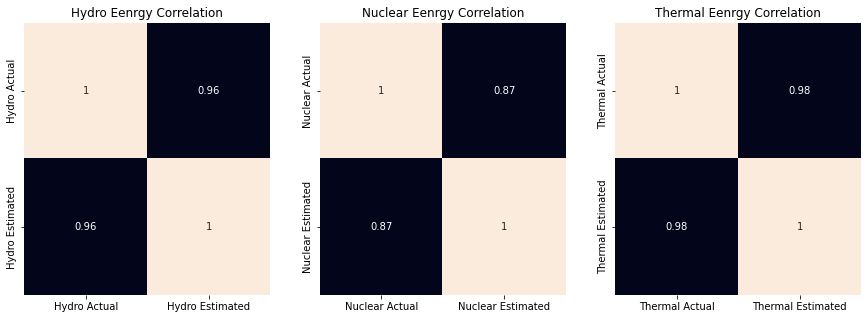

In [15]:
plt.figure(figsize=(15,5))
plt.subplot(131)
sns.heatmap(power_df.filter(regex="^Hydro.*").corr(), 
            annot=True, cbar=False,
            xticklabels=["Hydro Actual", "Hydro Estimated"],
            yticklabels=["Hydro Actual", "Hydro Estimated"])
plt.yticks(va="center")
plt.xticks(rotation=0)
plt.title("Hydro Eenrgy Correlation")

plt.subplot(132)
sns.heatmap(power_df.filter(regex="^Nuclear.*").corr(), 
            annot=True, cbar=False,
            xticklabels=["Nuclear Actual", "Nuclear Estimated"],
            yticklabels=["Nuclear Actual", "Nuclear Estimated"])
plt.yticks(va="center")
plt.xticks(rotation=0)
plt.title("Nuclear Eenrgy Correlation")

plt.subplot(133)
sns.heatmap(power_df.filter(regex="^Thermal.*").corr(), 
            annot=True, cbar=False,
            xticklabels=["Thermal Actual", "Thermal Estimated"],
            yticklabels=["Thermal Actual", "Thermal Estimated"])
plt.yticks(va="center")
plt.xticks(rotation=0)
plt.title("Thermal Eenrgy Correlation")

plt.show()

Well the Estimations and Actual values of all three energy are higly correlated, we don't even need a statistical test to confirm it.

Now let's sum the columns to get the total generation of energy, one for the actual value and one for the estiamted values.

In [16]:
power_df["Total Generation Actual"] = power_df.filter(regex=".*Actual.*").sum(axis=1)
power_df["Total Generation Estimated"] = power_df.filter(regex=".*Estimated.*").sum(axis=1)

Since the are all very highly correlated let's study only the Actual Power Generation.

Let's see the time plot of the Energy production in India.

In [17]:
power_by_date = power_df.groupby("Date")[power_columns.union(["Total Generation Actual",
                                                               "Total Generation Estimated"])].sum().reset_index()

In [18]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=power_by_date["Date"],
    y=power_by_date["Thermal Actual"],
    name='Thermal Generation',
    mode='lines'))
    
fig.add_trace(go.Scatter(
    x=power_by_date["Date"],
    y=power_by_date["Total Generation Actual"]/3,
    name='Average Generation',
    mode='lines'))


fig.add_trace(go.Scatter(
    x=power_by_date["Date"],
    y=power_by_date["Hydro Actual"],
    name='Hydro Generation',
    mode='lines'))

fig.add_trace(go.Scatter(
    x=power_by_date["Date"],
    y=power_by_date["Nuclear Actual"],
    name='Nuclear Generation',
    mode='lines'))

fig.update_layout(
    title={'text': "Power Generation in India",
        'y':0.95,
        'x':0.5},
    yaxis_title="Power Generation in MU",
    xaxis_title="",
    legend={'traceorder':'normal'})

fig.show()

Something happened 22 September 2017, there is a deep peak depression just that day, or maybe just a data error. Another thing we note is the dependency of power generation on the thermal resources, thus consuming a lot of fossil fuels, while the Nuclear Energy Generation is very low, when compared to the average Generation.

Let's see total energy consumption in 3 years grouped by regions, but it needs to be normalized for the number of states in each region to get an average of a state in a specific region, this is done because some regions have 10 states while some have only 2.

In [19]:
power_by_region = power_df.groupby("Region")[['Total Generation Actual','Thermal Actual',
                                             'Nuclear Actual','Hydro Actual']].sum().reset_index()

power_by_region = power_by_region.merge(state_distribution, on="Region")

power_by_region["Total Generation Actual"] = power_by_region["Total Generation Actual"]/power_by_region["Population"]*10000
power_by_region["Thermal Actual"] = power_by_region["Thermal Actual"]/power_by_region["Population"]*10000
power_by_region["Nuclear Actual"] = power_by_region["Nuclear Actual"]/power_by_region["Population"]*10000
power_by_region["Hydro Actual"] = power_by_region["Hydro Actual"]/power_by_region["Population"]*10000

In [20]:
figure = go.Figure()

figure.add_trace(go.Bar(x = power_by_region.Region,
                        y = power_by_region["Thermal Actual"],
                        name="Thermal", textposition='outside',
                        marker_color='#ef553b',
                        text=round(power_by_region["Thermal Actual"],2)))

figure.add_trace(go.Bar(x = power_by_region.Region,
                        y = power_by_region["Hydro Actual"],
                        name="Hydro",textposition='outside',
                        marker_color='#636efa',
                        text=round(power_by_region["Hydro Actual"],2)))

figure.add_trace(go.Bar(x = power_by_region.Region,
                        y = power_by_region["Nuclear Actual"],
                        name="Nuclear", textposition='outside',
                        marker_color='#2ca02c',
                        text=round(power_by_region["Nuclear Actual"],2)))

figure.update_layout(showlegend = True,
                     barmode='group',
                    title={'text': "Power Generation for every 10,000 person in each Region",
                    'y':0.95,
                    'x':0.5})